### Assignment 3 - Derivative types & Carts


by Généreux M. AKOTENOU

In [92]:
"""
En exécutant tout ce notebook, le dossier 'genereux_akotenou3' sera créé et il contiendra les fichiers Python de chaque exercice.
On pourra par la suite utiliser la commande suivante pour exécuter chaque script et voir les sorties :

$ mpirun -n <number> python3 <filename.py>
"""
import os
directory = 'genereux_akotenou3'
if not os.path.exists(directory):
    os.makedirs(directory)

In [99]:
%%file genereux_akotenou3/utils.py

"""
IMPORTANT: We must copy "utils" file provided for poisson exercise in the current folder ('genereux_akotenou3') so our script just above 
will work perfectly

TODOs: Just run this cell to get the utils file created 
"""

from sympy.ntheory import factorint
import numpy.ma as ma
import numpy as np

def compute_dims_uniform( mpi_size, npts ):

    nprocs = [1]*len( npts )

    mpi_factors   = factorint( int(mpi_size) )
    npts_factors  = [factorint( int(n) ) for n in npts]

    nprocs = [1 for n in npts]

    for a,power in mpi_factors.items():

        exponents = [f.get( a, 0 ) for f in npts_factors]

        for k in range( power ):

            i = np.argmax( exponents )
            max_exp = exponents[i]

            if exponents.count( max_exp ) > 1:
                i = ma.array( nprocs, mask=np.not_equal( exponents, max_exp ) ).argmin()

            nprocs   [i] *= a
            exponents[i] -= 1

            npts_factors[i][a] -= 1

    shape = [np.prod( [key**val for key,val in f.items()] ) for f in npts_factors]

    return nprocs, shape

def compute_dims_general( mpi_size, npts ):

    nprocs = [1]*len( npts )
    shape  = [n for n in npts]

    f = factorint( mpi_size, multiple=True )
    f.sort( reverse=True )

    for a in f:

        i = np.argmax( shape )
        max_shape = shape[i]

        if shape.count( max_shape ) > 1:
            i = ma.array( nprocs, mask=np.not_equal( shape, max_shape ) ).argmin()

        nprocs[i]  *= a
        shape [i] //= a

    return nprocs, shape

def compute_dims( nnodes, gridsizes, min_blocksizes=None, mpi=None ):

    assert nnodes > 0
    assert all( s > 0 for s in gridsizes )
    assert np.prod( gridsizes ) >= nnodes

    if (min_blocksizes is not None):
        assert len( min_blocksizes ) == len( gridsizes )
        assert all( m > 0 for m in gridsizes )
        assert all( s >= m for s,m in zip( gridsizes, min_blocksizes ) )

    # Determine whether uniform decomposition is possible
    uniform = (np.prod( gridsizes ) % nnodes == 0)

    # Compute dimensions of MPI Cartesian topology with most appropriate algorithm
    if uniform:
        dims, blocksizes = compute_dims_uniform( nnodes, gridsizes )
    else:
        dims, blocksizes = compute_dims_general( nnodes, gridsizes )

    # If a minimum block size is given, verify that condition is met

    if min_blocksizes is not None:
        too_small = any( [s < m for (s,m) in zip( blocksizes, min_blocksizes )] )

        # If uniform decomposition yields blocks too small, fall back to general algorithm
        if uniform and too_small:
            dims, blocksizes = compute_dims_general( nnodes, gridsizes )
            too_small = any( [s < m for (s,m) in zip( blocksizes, min_blocksizes )] )

        # If general decomposition yields blocks too small, raise error
        if too_small:
            raise ValueError("Cannot compute dimensions with given input values!")

    return dims, blocksizes

Overwriting genereux_akotenou3/utils.py


* Exercise 1: Game of Life Simulation

In [106]:
%%file genereux_akotenou3/exo1_gui.py

import numpy as np
#from mpi4py import MPI
import matplotlib.pyplot as plt
from tkinter import Tk, Canvas, Scale, HORIZONTAL, LEFT, RIGHT, BOTTOM, X

"""
IMPORTANT: We must copy "utils" file provided for poisson exercise in the current folder
"""
from utils import compute_dims

# Initialize comm utils
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

class GameOfLife:
    def __init__(self, max_transition, grid_row, grid_col, gui, pause_interval):
        # Genenral setup
        self.max_transition = int(max_transition)
        self.rows  = int(grid_row)
        self.cols  = int(grid_col)
        self.gui   = gui
        self.speed = pause_interval

        # Setup Cartesian topology
        self.dims, self.blocksizes = compute_dims(SIZE, [self.rows, self.cols])
        self.cart2d  = COMM.Create_cart(dims=self.dims, periods=None, reorder=False)

        # Global Grid & local-ghost Grid
        self.local_grid = np.zeros((self.blocksizes[0] + 2, self.blocksizes[1] + 2))
        self.local_grid[1:-1, 1:-1] = np.random.randint(2, size=(self.blocksizes[0], self.blocksizes[1]))
        if RANK == 0:
            self.global_grid  = np.zeros((self.dims[0]*self.blocksizes[0], self.dims[1]*self.blocksizes[1]))

        # Setup Tkinter GUI
        if self.gui:
            self.root = Tk()
            self.root.title("Game of Life")
            self.canvas = Canvas(self.root, width=self.cols * 10, height=self.rows * 10, bg="white")
            self.canvas.pack(side=LEFT)
            self.speed_slider = Scale(self.root, from_=0, to=1, resolution=0.1, orient=HORIZONTAL, label="Speed")
            self.speed_slider.pack(side=BOTTOM, fill=X)
            self.speed_slider.set(self.speed)

    def apply_rules(self):
        # Exchange boundary information
        TOP_PROCESS, BOTTOM_PROCESS = self.cart2d.Shift(direction=0, disp=1)
        LEFT_PROCESS, RIGHT_PROCESS = self.cart2d.Shift(direction=1, disp=1)

        self.cart2d.Sendrecv(self.local_grid[1, 1:-1], dest=TOP_PROCESS, recvbuf=self.local_grid[-1, 1:-1], source=BOTTOM_PROCESS)
        self.cart2d.Sendrecv(self.local_grid[-2, 1:-1], dest=BOTTOM_PROCESS, recvbuf=self.local_grid[0, 1:-1], source=TOP_PROCESS)
        
        recv_right_col = np.zeros(self.blocksizes[0])
        self.cart2d.Sendrecv(np.ascontiguousarray(self.local_grid[1:-1, 1]), dest=LEFT_PROCESS, recvbuf=recv_right_col, source=RIGHT_PROCESS)
        self.local_grid[1:-1, -1] = recv_right_col

        recv_left_col = np.zeros(self.blocksizes[0])
        self.cart2d.Sendrecv(np.ascontiguousarray(self.local_grid[1:-1, -2]), dest=RIGHT_PROCESS, recvbuf=recv_left_col, source=LEFT_PROCESS)
        self.local_grid[1:-1, 0] = recv_left_col

        # Extract neighbors submatrix & apply game rules
        local_grid_copy = self.local_grid.copy()
        for i in range(1, self.blocksizes[0]+1):
            for j in range(1, self.blocksizes[1]+1):
                neighbors_matrix = local_grid_copy[i-1:i+2, j-1:j+2]
                neighbors_alive  = np.sum(neighbors_matrix) - local_grid_copy[i, j]
                if local_grid_copy[i, j] == 1:
                    if neighbors_alive < 2 or neighbors_alive > 3:
                        self.local_grid[i, j] = 0 
                    else:
                        self.local_grid[i, j] = 1
                else: 
                    if neighbors_alive == 3:
                        self.local_grid[i, j] = 1

    def visu(self, i):
        if not hasattr(self, 'fig'):
            self.fig, self.ax = plt.subplots(figsize=(8, 8))
            cmap = plt.matplotlib.colors.ListedColormap(['gray', 'yellow'])
            for i in range(self.rows+1):
                self.ax.axhline(i-0.5, color='#939292', lw=0.5)
            for j in range(self.cols+1):
                self.ax.axvline(j-0.5, color='#939292', lw=0.5)
            self.img = self.ax.imshow(self.global_grid, cmap=cmap)
        else:
            self.img.set_data(self.global_grid)

        self.ax.set_title(f"Iteration: {i+1}/{self.max_transition} - Over: {SIZE} process - Board: ({self.rows}x{self.cols})")
        plt.draw()
        if self.speed != 0:
            plt.pause(self.speed)

    def update_gui(self):
        self.canvas.delete("all")
        for i in range(self.rows):
            for j in range(self.cols):
                color = "black" if self.global_grid[i, j] == 1 else "white"
                self.canvas.create_rectangle(j * 10, i * 10, (j + 1) * 10, (i + 1) * 10, fill=color)

    def play(self):
        for i in range(self.max_transition):
            # next state
            self.apply_rules()

            # Gather new state
            COMM.Barrier()
            all_local_grid = COMM.gather(self.local_grid , root=0)
            if RANK == 0:
                for j in range(SIZE):
                    coord = self.cart2d.Get_coords(j)
                    row_start = coord[0]*self.blocksizes[0]
                    row_end   = coord[0]*self.blocksizes[0] + self.blocksizes[0]
                    col_start = coord[1]*self.blocksizes[1]
                    col_end   = coord[1]*self.blocksizes[1] + self.blocksizes[1]
                    self.global_grid[row_start:row_end, col_start:col_end] = all_local_grid[j][1:-1,1:-1]

                # Visualization
                if self.gui:
                    if i == 0:
                        self.update_gui()
                    self.root.update_idletasks()
                    self.root.update()
                    self.speed = self.speed_slider.get()
                    if self.speed != 0:
                        plt.pause(self.speed)

        if self.gui:
            self.root.mainloop()

# Main
game = GameOfLife(max_transition=100, grid_row=25, grid_col=30, gui=True, pause_interval=0.3)
game.play()

Overwriting genereux_akotenou3/exo1_gui.py


**Analysis**:
When dealing with topologies like 2*2, we realize that to have all the neighbors of the extreme elements (for example, the bottom-left corner), we need data located in the top-right corner of a process diagonally opposite. Therefore, we wonder how to obtain this information. To address this issue, we proposed performing communications along one axis (top-bottom and bottom-top) for all processes before performing exchanges on the sides. This ensured that the elements are not missing in each process.
<br><br>
See the diagram below:
<br><br>
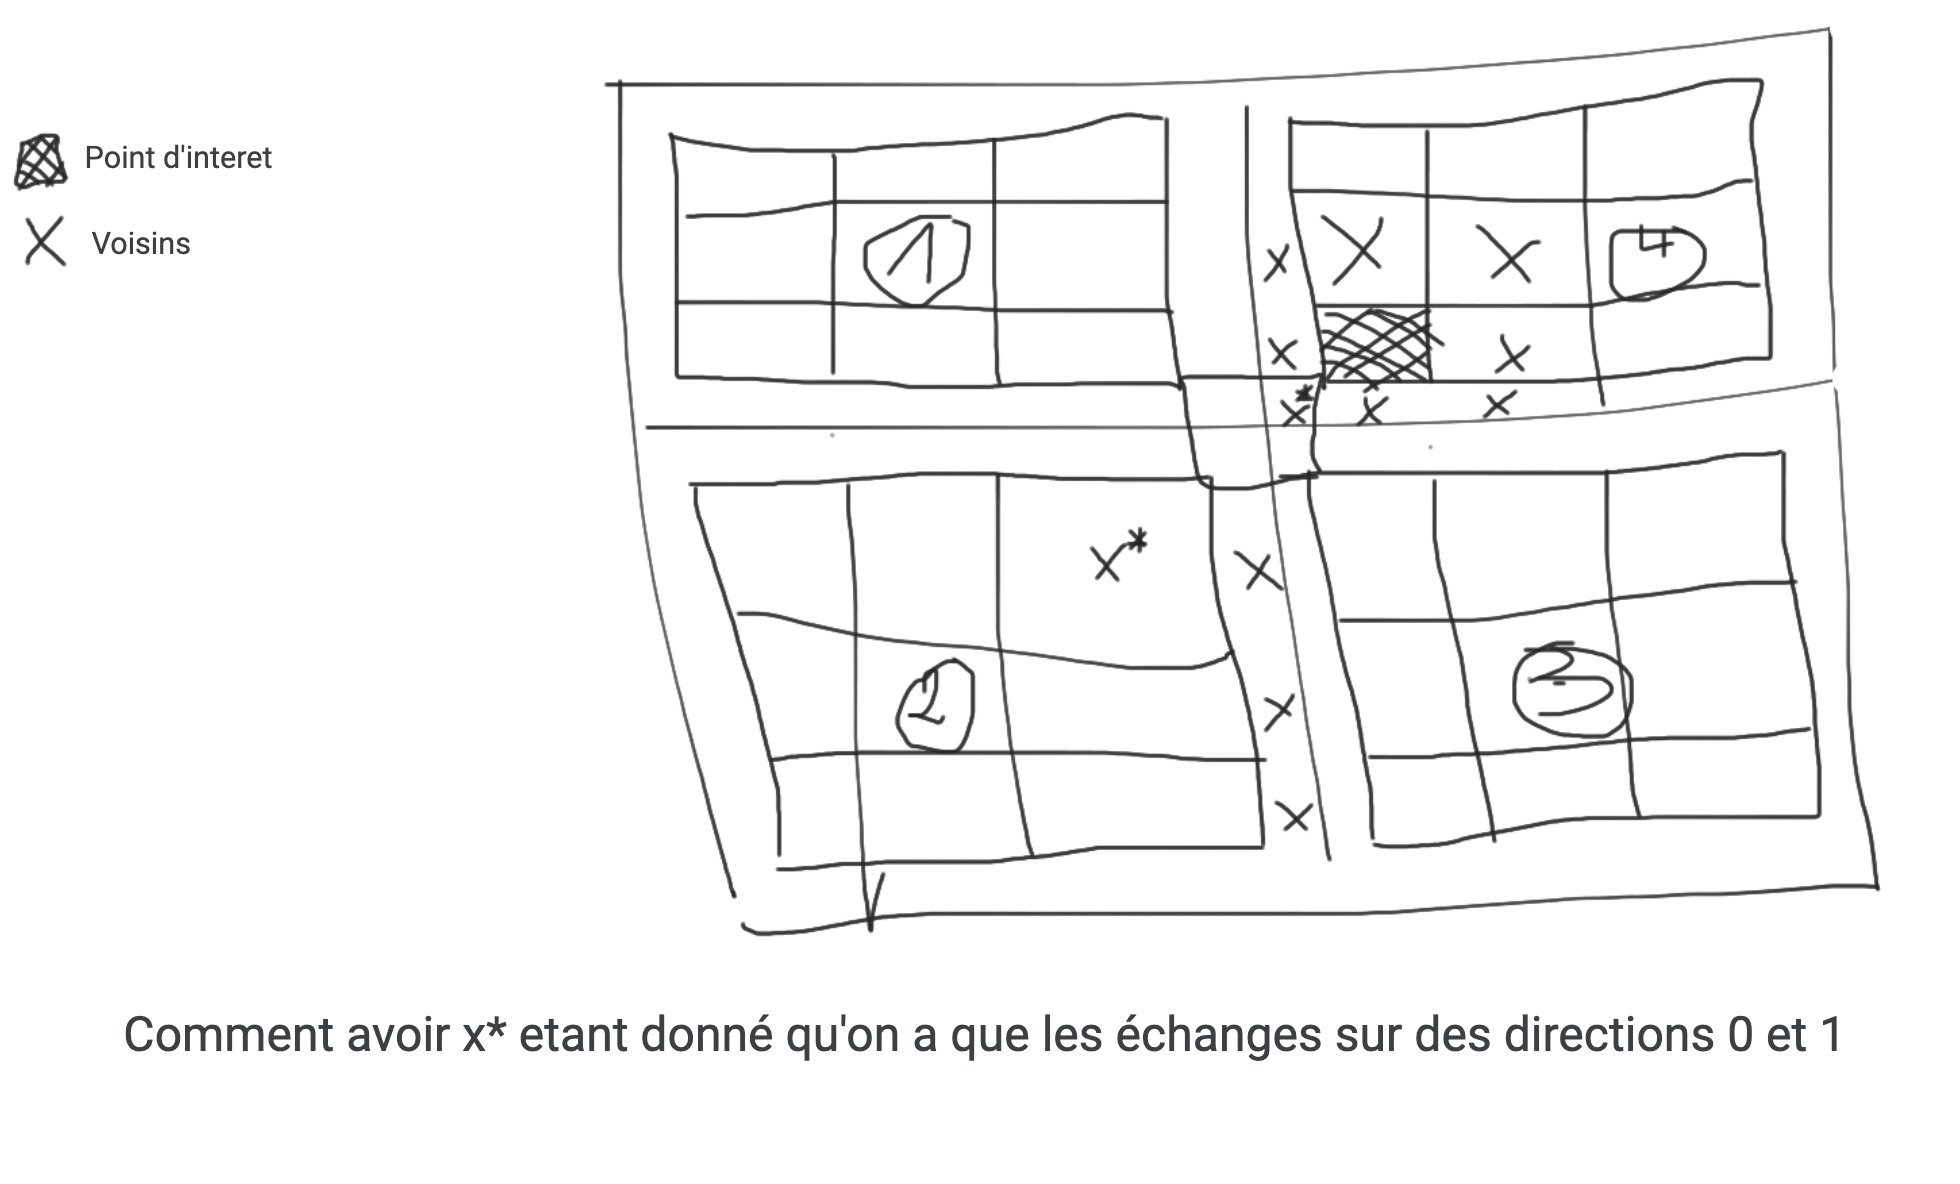

In [5]:
%%file genereux_akotenou3/exo1.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

"""
IMPORTANT: We must copy "utils" file provided for poisson exercise in the current folder
"""
from utils import compute_dims

# Initialize comm utils
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

class GameOfLife:
    def __init__(self, max_transition, grid_row, grid_col, gui, pause_interval):
        # Genenral setup
        self.max_transition = int(max_transition)
        self.rows  = int(grid_row)
        self.cols  = int(grid_col)
        self.gui   = gui
        self.speed = pause_interval

        # Setup Cartesian topology
        self.dims, self.blocksizes = compute_dims(SIZE, [self.rows, self.cols])
        self.cart2d  = COMM.Create_cart(dims=self.dims, periods=None, reorder=False)

        # Global Grid & local-ghost Grid
        self.local_grid = np.zeros((self.blocksizes[0] + 2, self.blocksizes[1] + 2))
        self.local_grid[1:-1, 1:-1] = np.random.randint(2, size=(self.blocksizes[0], self.blocksizes[1]))
        if RANK == 0:
            self.global_grid  = np.zeros((self.dims[0]*self.blocksizes[0], self.dims[1]*self.blocksizes[1]))
    
    def apply_rules(self):
        # Exchange boundary information
        TOP_PROCESS, BOTTOM_PROCESS = self.cart2d.Shift(direction=0, disp=1)
        LEFT_PROCESS, RIGHT_PROCESS = self.cart2d.Shift(direction=1, disp=1)

        self.cart2d.Sendrecv(self.local_grid[1, 1:-1], dest=TOP_PROCESS, recvbuf=self.local_grid[-1, 1:-1], source=BOTTOM_PROCESS)
        self.cart2d.Sendrecv(self.local_grid[-2, 1:-1], dest=BOTTOM_PROCESS, recvbuf=self.local_grid[0, 1:-1], source=TOP_PROCESS)
        self.cart2d.Barrier()

        recv_right_col = np.zeros(self.blocksizes[0]+2)
        self.cart2d.Sendrecv(np.ascontiguousarray(self.local_grid[:, 1]), dest=LEFT_PROCESS, recvbuf=recv_right_col, source=RIGHT_PROCESS)
        self.local_grid[:, -1] = recv_right_col

        recv_left_col = np.zeros(self.blocksizes[0]+2)
        self.cart2d.Sendrecv(np.ascontiguousarray(self.local_grid[:, -2]), dest=RIGHT_PROCESS, recvbuf=recv_left_col, source=LEFT_PROCESS)
        self.local_grid[:, 0] = recv_left_col

        # Extract neighbors submatrix & apply game rules
        local_grid_copy = self.local_grid.copy()
        for i in range(1, self.blocksizes[0]+1):
            for j in range(1, self.blocksizes[1]+1):
                neighbors_matrix = local_grid_copy[i-1:i+2, j-1:j+2]
                neighbors_alive  = np.sum(neighbors_matrix) - local_grid_copy[i, j]
                if local_grid_copy[i, j] == 1:
                    if neighbors_alive < 2 or neighbors_alive > 3:
                        self.local_grid[i, j] = 0 
                    else:
                        self.local_grid[i, j] = 1
                else: 
                    if neighbors_alive == 3:
                        self.local_grid[i, j] = 1
    
    def visu(self, i):
        if not hasattr(self, 'fig'):
            self.fig, self.ax = plt.subplots(figsize=(8, 8))
            cmap = plt.matplotlib.colors.ListedColormap(['gray', 'yellow'])
            for i in range(self.rows+1):
                self.ax.axhline(i-0.5, color='#939292', lw=0.5)
            for j in range(self.cols+1):
                self.ax.axvline(j-0.5, color='#939292', lw=0.5)
            self.img = self.ax.imshow(self.global_grid, cmap=cmap)
        else:
            self.img.set_data(self.global_grid)

        self.ax.set_title(f"Iteration: {i+1}/{self.max_transition} - Over: {SIZE} process - Board: ({self.rows}x{self.cols})")
        plt.draw()
        if self.speed != 0:
            plt.pause(self.speed)

    def play(self):
        for i in range(self.max_transition):
            # next state
            self.apply_rules()

            # Gather new state
            COMM.Barrier()
            all_local_grid = COMM.gather(self.local_grid , root=0)
            if RANK == 0:
                for j in range(SIZE):
                    coord = self.cart2d.Get_coords(j)
                    row_start = coord[0]*self.blocksizes[0]
                    row_end   = coord[0]*self.blocksizes[0] + self.blocksizes[0]
                    col_start = coord[1]*self.blocksizes[1]
                    col_end   = coord[1]*self.blocksizes[1] + self.blocksizes[1]
                    self.global_grid[row_start:row_end, col_start:col_end] = all_local_grid[j][1:-1,1:-1]
                print(f"transition: ", i+1)
                print(self.global_grid)

                # Visualization
                if self.gui:
                    self.visu(i)
        plt.show()

# Main
game = GameOfLife(max_transition=200, grid_row=55, grid_col=50, gui=True, pause_interval=0.3)
game.play()

Overwriting genereux_akotenou3/exo1.py


In [100]:
# OUTPUT
# % mpirun -n 4 python3 genereux_akotenou3/exo1.py

# transition:  0
# [[1. 1. 1. 0.]
#  [0. 0. 0. 1.]
#  [1. 0. 1. 0.]
#  [1. 1. 1. 0.]]
# transition:  1
# [[0. 1. 1. 0.]
#  [1. 0. 0. 1.]
#  [1. 0. 1. 1.]
#  [1. 0. 1. 0.]]
# transition:  2
# [[0. 1. 1. 0.]
#  [1. 0. 0. 1.]
#  [1. 0. 1. 1.]
#  [0. 0. 1. 1.]]

<h5>If you use gui=True you will get this kind of visual interface: </h5>
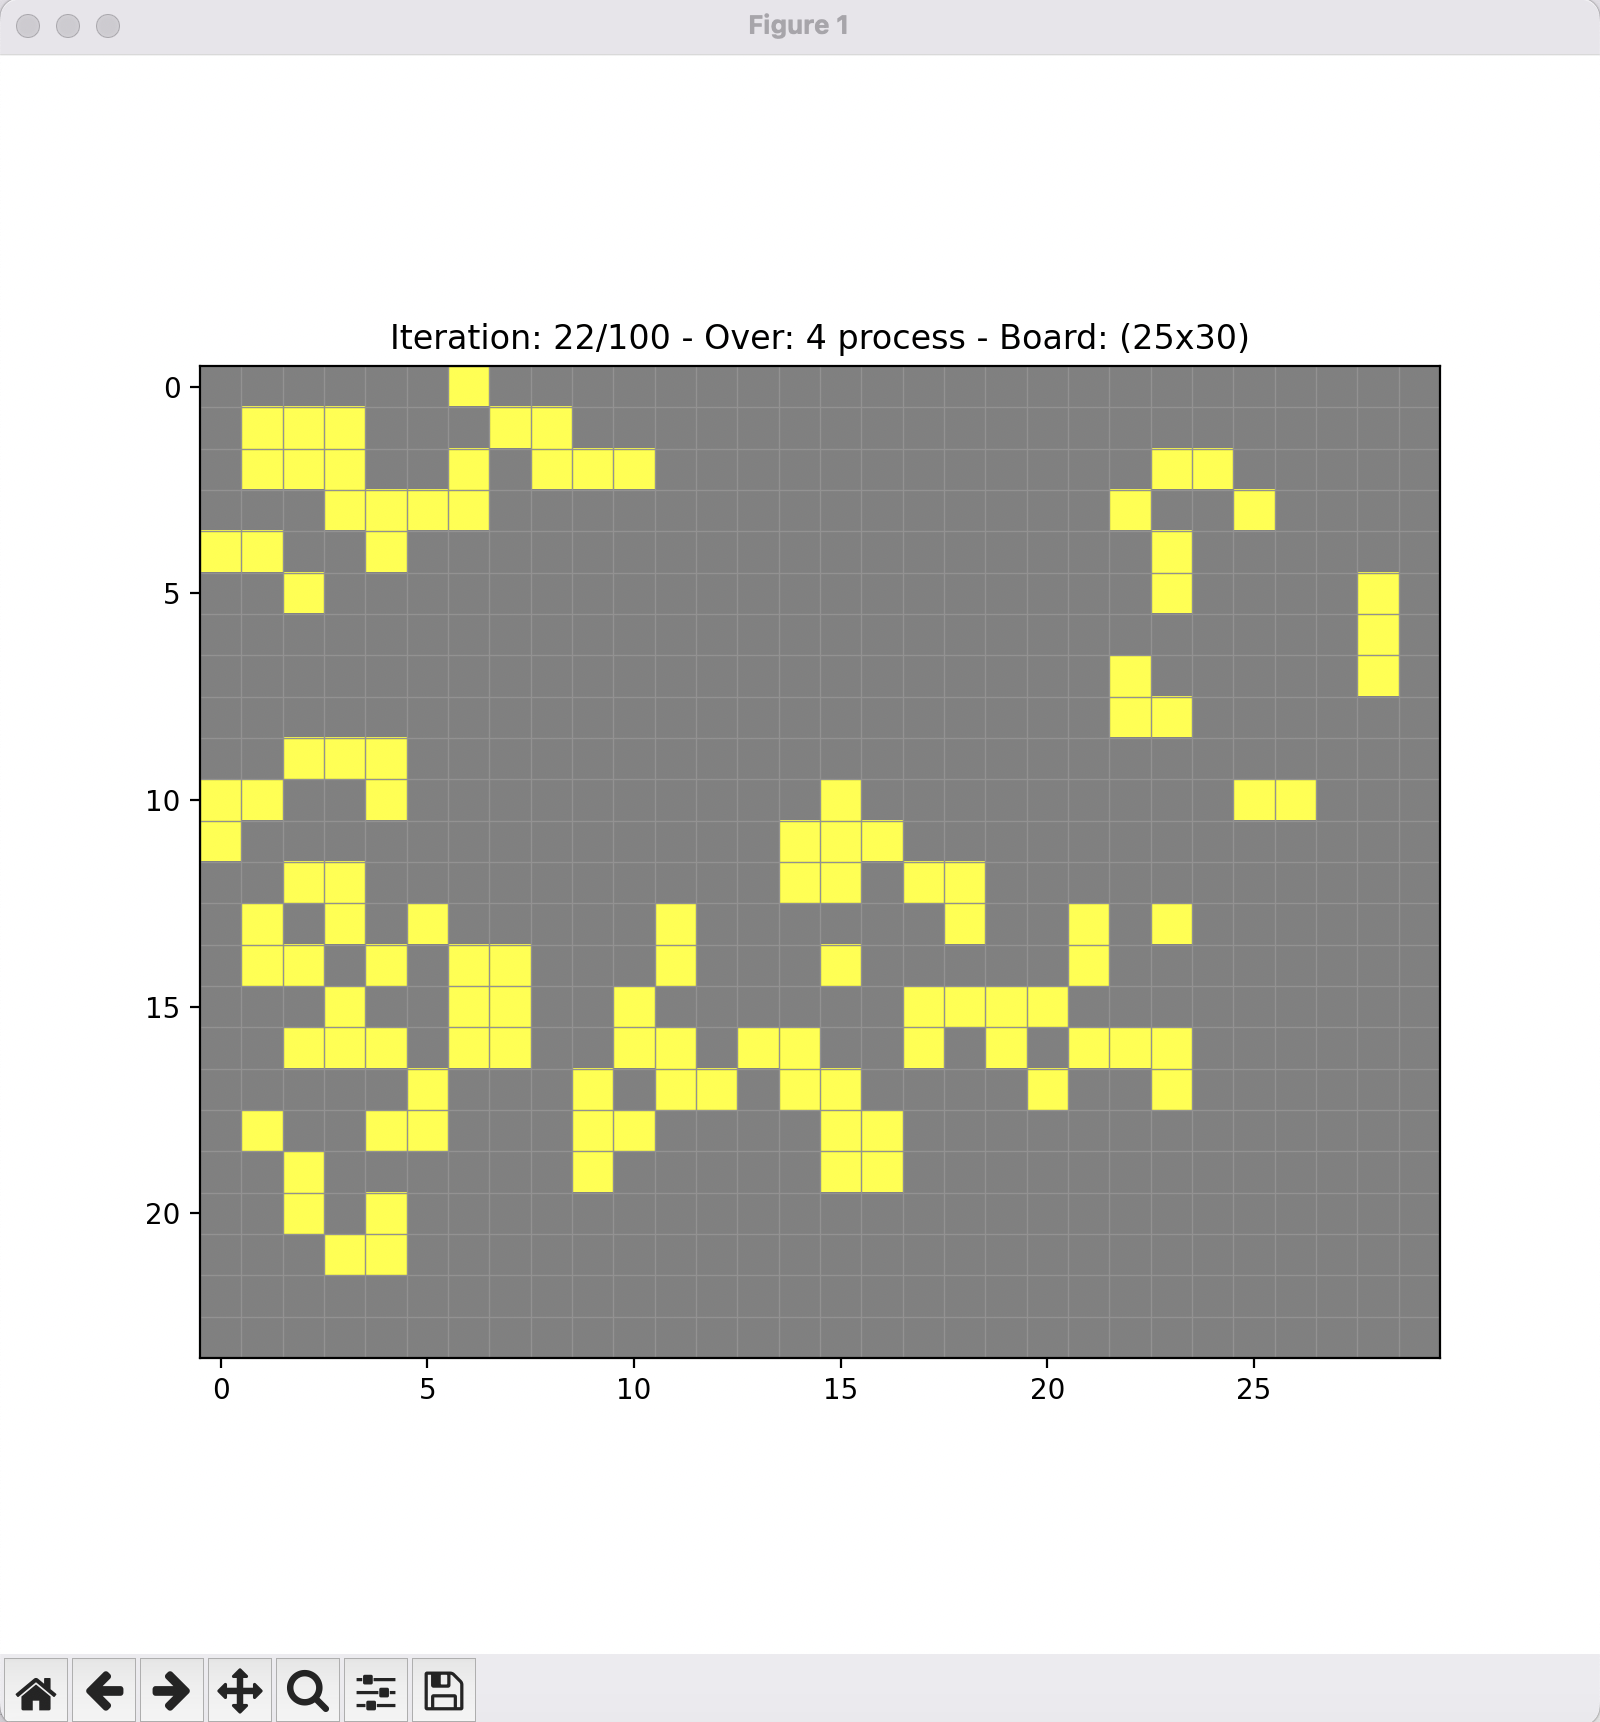

* Exercise 2: Complete poisson_empty.py

In [8]:
%%file genereux_akotenou3/exo2_poisson.py

#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
/*
 *   Solving the Poisson's equation discretized on the [0,1]x[0,1] domain
 *   using the finite difference method and a Jacobi's iterative solver.
 *
 *   Delta u = f(x,y)= 2*(x*x-x+y*y -y)
 *   u equal 0 on the boudaries
 *   The exact solution is u = x*y*(x-1)*(y-1)
 *
 *   The u value is :
 *    coef(1) = (0.5*hx*hx*hy*hy)/(hx*hx+hy*hy)
 *    coef(2) = 1./(hx*hx)
 *    coef(3) = 1./(hy*hy)
 *
 *    u(i,j)(n+1)= coef(1) * (  coef(2)*(u(i+1,j)+u(i-1,j)) &
 *               + coef(3)*(u(i,j+1)+u(i,j-1)) - f(i,j))
 *
 *   ntx and nty are the total number of interior points along x and y, respectivly.
 * 
 *   hx is the grid spacing along x and hy is the grid spacing along y.
 *    hx = 1./(ntx+1)
 *    hy = 1./(nty+1)
 *
 *   On each process, we need to:
 *   1) Split up the domain
 *   2) Find our 4 neighbors
 *   3) Exchange the interface points
 *   4) Calculate u
 *
 *   @author: kissami
 */
"""

# Import dependencies
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from utils import compute_dims

# Initialize comm utils
comm = MPI.COMM_WORLD
nb_procs = comm.Get_size()
rank = comm.Get_rank()

# Neighbours
nb_neighbours = 4
neighbour = np.zeros(nb_neighbours, dtype=np.int8)
N = 0
E = 1
S = 2
W = 3

# Discretization & Grid spacing
ntx = 6
nty = 4
Nx  = ntx+2
Ny  = nty+2
hx  = 1/(ntx+1)
hy  = 1/(nty+1)

# Equation Coefficients
coef    = np.zeros(3)
coef[0] = (0.5*hx*hx*hy*hy)/(hx*hx+hy*hy)
coef[1] = 1./(hx*hx)
coef[2] = 1./(hy*hy)

# Setup for cartesian topology
npoints = [ntx, nty]
p1 = [2,2]
P1 = [False, False]
reorder = True

# --------------------------------------------------------
# UTILS
# --------------------------------------------------------
def create_2d_cart(npoints, p1, P1, reorder):
    # Store input arguments                                                                                                                                                                                                                                               
    npts    = tuple(npoints)
    pads    = tuple(p1)
    periods = tuple(P1)
    reorder = reorder
    
    nprocs, _ = compute_dims(nb_procs, npts, pads)
    dims = nprocs
    
    '''
    * Creation of the Cartesian topology
    '''
    cart2d = comm.Create_cart(dims=dims, periods=periods, reorder=reorder)

    if (rank == 0):
        print("Execution poisson with",nb_procs," MPI processes\n"
               "Size of the domain : ntx=",npoints[0], " nty=",npoints[1],"\n"
               "Dimension for the topology :",dims[0]," along x", dims[1]," along y\n"
               "-----------------------------------------")

    return dims, cart2d

def create_2dCoords(cart2d, npoints, dims):
    ''' Create 2d coordinates of each process'''
    coords_2d = cart2d.Get_coords(rank)
    sx = int((coords_2d[0]*npoints[0])/dims[0]+1)
    ex = int(((coords_2d[0]+1)*npoints[0])/dims[0])
    sy = int((coords_2d[1]*npoints[1])/dims[1]+1)
    ey = int(((coords_2d[1]+1)*npoints[1])/dims[1])

    print("Rank in the topology :",rank," Local Grid Index :", sx, " to ",ex," along x, ",
          sy, " to", ey," along y")
    
    return sx, ex, sy, ey

def create_neighbours(cart2d):
    ''' Get my northern and southern neighbours '''
    neighbour[N], neighbour[S] = cart2d.Shift(direction=0, disp=1)
    ''' Get my western and eastern neighbours '''
    neighbour[W], neighbour[E] = cart2d.Shift(direction=1, disp=1)
    
    print("Process", rank," neighbour: N", neighbour[N]," E",neighbour[E] ," S ",neighbour[S],
          " W",neighbour[W])
    
    return neighbour

'''Creation of the derived datatypes needed to exchange points with neighbours'''
def create_derived_type(sx, ex, sy, ey):
    '''Creation of the type_line derived datatype to exchange points
     with northern to southern neighbours '''
    stride = ey - sy + 3
    type_line = MPI.DOUBLE.Create_vector(ex - sx + 3, 1, stride)
    type_line.Commit()

    '''Creation of the type_column derived datatype to exchange points
     with western to eastern neighbours '''
    type_column = MPI.DOUBLE.Create_contiguous(ey - sy + 3)
    type_column.Commit()
     
    return type_line, type_column

''' Exchange the points at the interface '''
def communications(u, sx, ex, sy, ey, type_column, type_ligne):
    
    ''' Send to neighbour N and receive from neighbour S '''
    # u[1:]          -> We exclude first element so by appying 'type_line' we'll retrive second line of matrix U
    # u[(ey-sy+2):]  -> We exclude all element of the left ghost_cell except the last one
    cart2d.Sendrecv([u[1:], 1, type_ligne], dest=neighbour[N], recvbuf=[u[(ey-sy+2):], 1, type_ligne], source=neighbour[S])

    ''' Send to neighbour S and receive from neighbour N '''
    # u[(ey-sy+1):]  -> This ensures that the vectorized form of 'u' starts from the second element from the bottom of the left column
    # u              -> By leaving u unchanged for reception, the 'type_line' will write to the first row of the equivalent of matrix U.
    cart2d.Sendrecv([u[(ey-sy+1):], 1, type_ligne], dest=neighbour[S], recvbuf=[u, 1, type_ligne], source=neighbour[N])

    ''' Send to neighbour W and receive from neighbour E '''
    # u[ey-sy+3:]    -> We exclude first left ghost_cell to send inner left column data to right side process
    # u[-(ey-sy+3):] -> We select last col of matrix U in vector u yo stock incomming data from right side process
    cart2d.Sendrecv([u[ey-sy+3:], 1, type_column], dest=neighbour[W], recvbuf=[u[-(ey-sy+3):], 1, type_column], source=neighbour[E])

    ''' Send to neighbour E  and receive from neighbour W '''
    #u[-2*(ey-sy+3):]-> This ensures that we send the -2 col from right to right side process
    # u              -> We receive at first 'ey-sy+3' position of u
    cart2d.Sendrecv([u[-2*(ey-sy+3):], 1, type_column], dest=neighbour[E], recvbuf=[u, 1, type_column], source=neighbour[W])

    # reinit corner values (not mandatory)
    u[0] = u[-1] = u[(ey-sy+2)] = u[-(ey-sy+3)] = 0

'''
 * IDX(i, j) : indice de l'element i, j dans le tableau u
 * sx-1 <= i <= ex+1
 * sy-1 <= j <= ey+1
'''
def IDX(i, j):
    return ( ((i)-(sx-1))*(ey-sy+3) + (j)-(sy-1) )

def initialization(sx, ex, sy, ey):
    ''' Grid spacing in each dimension'''
    space_x = ex-sx+3
    space_y = ey-sy+3
    SIZE = space_x * space_y

    ''' Solution u and u_new at the n and n+1 iterations '''
    u       = np.zeros(SIZE)
    u_new   = np.zeros(SIZE)
    f       = np.zeros(SIZE)
    u_exact = np.zeros(SIZE)

    '''Initialition of rhs f and exact soluction '''
    # Utils
    func_u_exact = lambda x,y: x*y*(x-1)*(y-1)
    func_rhs_f   = lambda x,y: 2*(x*x-x+y*y -y)
    # Iter
    for i, iterx in enumerate(range(sx, ex+1, 1)):
        for j, itery in enumerate(range(sy, ey+1, 1)):
            u_exact[IDX(i+1, j+1)] = func_u_exact(iterx*hx, itery*hy)
            f[IDX(i+1, j+1)] = func_rhs_f(iterx*hx, itery*hy)
    return u, u_new, u_exact, f

def computation(u, u_new):
    ''' Compute the new value of u using '''
    for i in range(1, ex-sx+2):
        for j in range(1, ey-sy+2):
            u_new[IDX(i, j)] = coef[0] * (coef[1] * (u[IDX(i+1, j)] + u[IDX(i-1, j)]) + coef[2] * (u[IDX(i, j+1)] + u[IDX(i, j-1)]) - f[IDX(i, j)])
 
def output_results(u, u_exact):
    print("Exact Solution u_exact - Computed Solution u - difference")
    for itery in range(sy, ey+1, 1):
        print(u_exact[IDX(1, itery)], '-', u[IDX(1, itery)], u_exact[IDX(1, itery)]-u[IDX(1, itery)])

''' Calcul for the global error (maximum of the locals errors) '''
def global_error(u, u_new):
    local_error = 0
    for iterx in range(sx, ex+1, 1):
        for itery in range(sy, ey+1, 1):
            temp = np.fabs( u[IDX(iterx, itery)] - u_new[IDX(iterx, itery)])
            if local_error < temp:
                local_error = temp
    return local_error

def plot_2d(f):
    # mesh 
    f = np.reshape(f, (ex-sx+3, ey-sy+3))
    x = np.linspace(0, 1, ey-sy+3)
    y = np.linspace(0, 1, ex-sx+3)
    
    # figure
    fig = plt.figure(figsize=(7, 5), dpi=100)
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(x, y)      
    ax.plot_surface(X, Y, f, cmap=cm.viridis)
    plt.show()

def plot_2d(f, ax, title):
    # mesh 
    f = np.reshape(f, (ex-sx+3, ey-sy+3))
    x = np.linspace(0, 1, ey-sy+3)
    y = np.linspace(0, 1, ex-sx+3)
    
    # plot
    X, Y = np.meshgrid(x, y)      
    ax.plot_surface(X, Y, f, cmap=cm.viridis)
    ax.set_title(title)


# --------------------------------------------------------
# MAIN
# --------------------------------------------------------
dims, cart2d   = create_2d_cart(npoints, p1, P1, reorder)
neighbour      = create_neighbours(cart2d)

sx, ex, sy, ey = create_2dCoords(cart2d, npoints, dims)

type_ligne, type_column = create_derived_type(sx, ex, sy, ey)
u, u_new, u_exact, f    = initialization(sx, ex, sy, ey)

''' Time stepping '''
it = 0
convergence = False
it_max = 100000
eps = 2.e-16

''' Elapsed time '''
t1 = MPI.Wtime()

#import sys; sys.exit()
while (not(convergence) and (it < it_max)):
    it = it+1
    temp = u.copy() 
    u = u_new.copy() 
    u_new = temp.copy()
    
    ''' Exchange of the interfaces at the n iteration '''
    communications(u, sx, ex, sy, ey, type_column, type_ligne)
   
    ''' Computation of u at the n+1 iteration '''
    computation(u, u_new)
    
    ''' Computation of the global error '''
    local_error = global_error(u, u_new)
    diffnorm = comm.allreduce(np.array(local_error), op=MPI.MAX )   
   
    ''' Stop if we obtained the machine precision '''
    convergence = (diffnorm < eps)
    
    ''' Print diffnorm for process 0 '''
    if ((rank == 0) and ((it % 100) == 0)):
        print("Iteration", it, " global_error = ", diffnorm)
        
''' Elapsed time '''
t2 = MPI.Wtime()

if (rank == 0):
    ''' Print convergence time for process 0 '''
    print("Convergence after",it, 'iterations in', t2-t1,'secs')

    ''' Compare to the exact solution on process 0 '''
    output_results(u, u_exact)

    ''' We want to render both exact and approximate solution '''
    fig = plt.figure(figsize=(10, 6), dpi=100)
    ax0 = fig.add_subplot(121, projection='3d')
    ax1 = fig.add_subplot(122, projection='3d')
    plot_2d(u_exact, ax0, "Exact solution on Process 0")
    plot_2d(u, ax1, "Approximate solution on Process 0")
    plt.tight_layout()
    plt.show()

Overwriting genereux_akotenou3/exo2_poisson.py


In [98]:
# OUTPUT
# % mpirun -n 4 python3 genereux_akotenou3/exo2_poisson.py

# Process 1  neighbour: N -2  E -2  S  3  W 0
# Rank in the topology : 1  Local Grid Index : 1  to  3  along x,  3  to 4  along y
# Process 2  neighbour: N 0  E 3  S  -2  W -2
# Rank in the topology : 2  Local Grid Index : 4  to  6  along x,  1  to 2  along y
# Execution poisson with 4  MPI processes
# Size of the domain : ntx= 6  nty= 4 
# Dimension for the topology : 2  along x 2  along y
# -----------------------------------------
# Process 0  neighbour: N -2  E 1  S  2  W -2
# Rank in the topology : 0  Local Grid Index : 1  to  3  along x,  1  to 2  along y
# Process 3  neighbour: N 1  E -2  S  -2  W 2
# Rank in the topology : 3  Local Grid Index : 4  to  6  along x,  3  to 4  along y
# Convergence after 72 iterations in 0.003436 secs
# Exact Solution u_exact - Computed Solution u - difference
# 0.01959183673469388 - 0.011433454715776219 0.008158382018917661
# 0.02938775510204082 - 0.01298056322835514 0.01640719187368568

On a obtenu le rendu çi-apres sur le process 0:
<br><br>
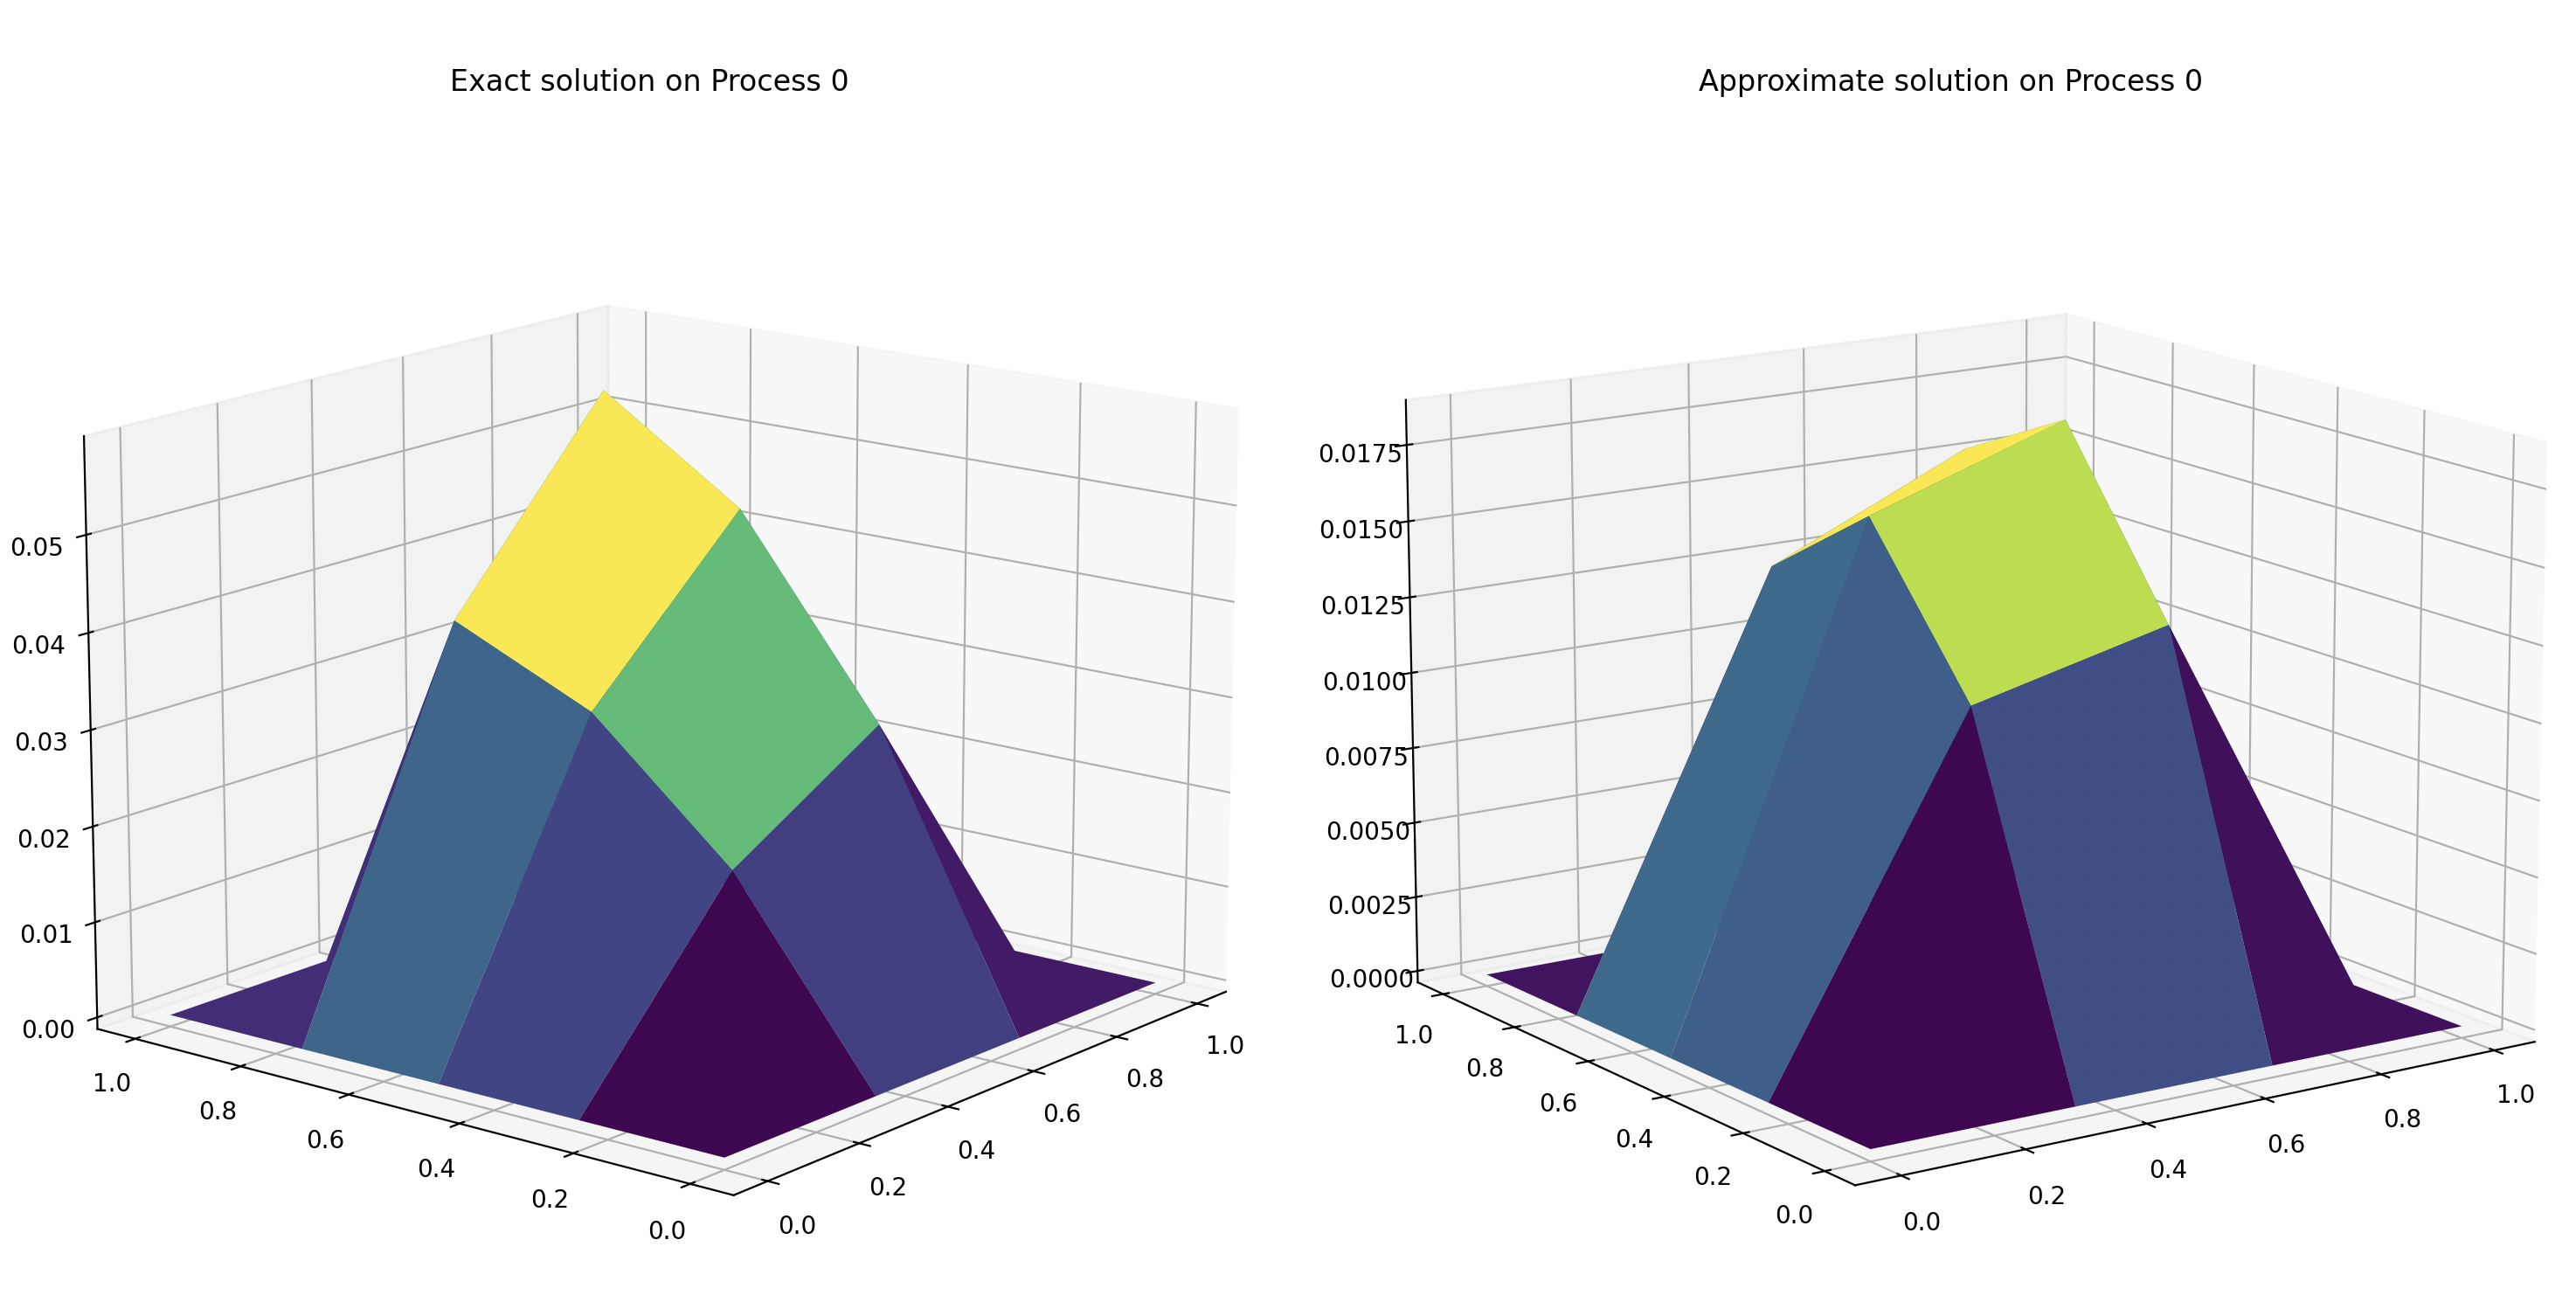